# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus: 
    #tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [47]:
data_dir = 'TBTrain' 

In [48]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [49]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [50]:
import numpy as np
from matplotlib import pyplot as plt

In [52]:
data = tf.keras.utils.image_dataset_from_directory('TBTrain')

Found 5246 files belonging to 2 classes.


In [53]:
data_iterator = data.as_numpy_iterator()

In [54]:
batch = data_iterator.next()

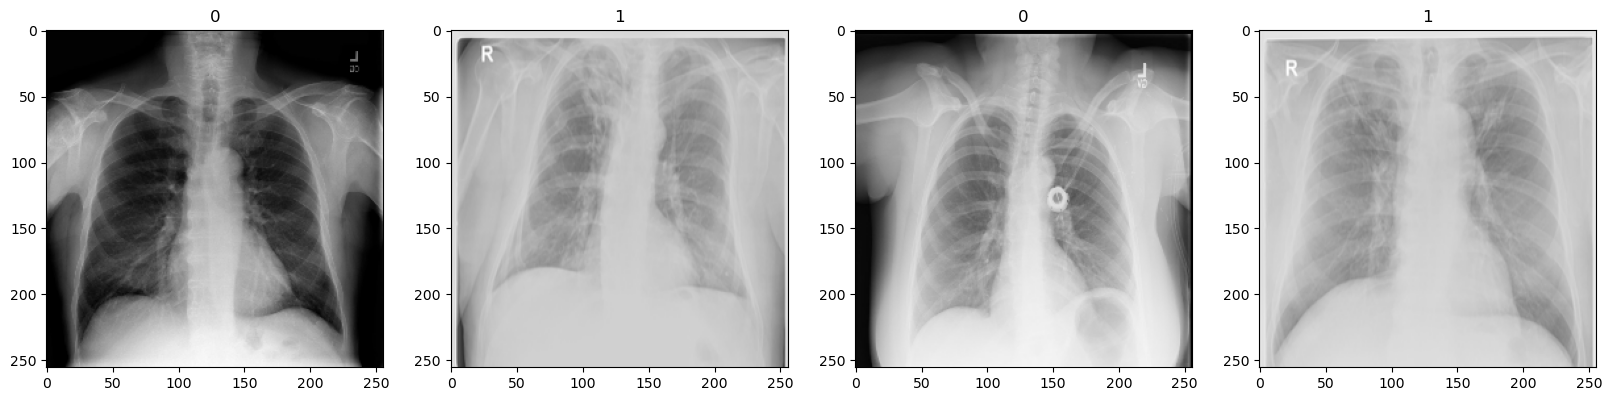

In [55]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [56]:
data = data.map(lambda x,y: (x/255, y))

In [57]:
data.as_numpy_iterator().next()

(array([[[[0.8245098 , 0.8245098 , 0.8245098 ],
          [0.79901963, 0.79901963, 0.79901963],
          [0.7882353 , 0.7882353 , 0.7882353 ],
          ...,
          [0.43529412, 0.43529412, 0.43529412],
          [0.44117647, 0.44117647, 0.44117647],
          [0.48039216, 0.48039216, 0.48039216]],
 
         [[0.78039217, 0.78039217, 0.78039217],
          [0.75686276, 0.75686276, 0.75686276],
          [0.6852941 , 0.6852941 , 0.6852941 ],
          ...,
          [0.05882353, 0.05882353, 0.05882353],
          [0.06372549, 0.06372549, 0.06372549],
          [0.05490196, 0.05490196, 0.05490196]],
 
         [[0.7205882 , 0.7205882 , 0.7205882 ],
          [0.5980392 , 0.5980392 , 0.5980392 ],
          [0.3764706 , 0.3764706 , 0.3764706 ],
          ...,
          [0.00196078, 0.00196078, 0.00196078],
          [0.00196078, 0.00196078, 0.00196078],
          [0.00196078, 0.00196078, 0.00196078]],
 
         ...,
 
         [[0.18431373, 0.18431373, 0.18431373],
          [0.06078

# 5. Split Data

In [58]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [59]:
train_size

114

In [60]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [61]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [63]:
model = Sequential()

In [64]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\victor.CHRISTTECH\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [67]:
logdir='logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.7487 - loss: 0.5146 - val_accuracy: 0.8916 - val_loss: 0.2723
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9001 - loss: 0.2550 - val_accuracy: 0.9121 - val_loss: 0.1895
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9238 - loss: 0.1969 - val_accuracy: 0.9502 - val_loss: 0.1586
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9519 - loss: 0.1284 - val_accuracy: 0.9512 - val_loss: 0.1270
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9587 - loss: 0.1035 - val_accuracy: 0.9600 - val_loss: 0.1140
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9756 - loss: 0.0794 - val_accuracy: 0.9668 - val_loss: 0.0974
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9761 - loss: 0.0593 - val_accuracy: 0.9707 - val_loss: 0.0916
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9872 - loss: 0.0387 - val_accu

# 8. Plot Performance

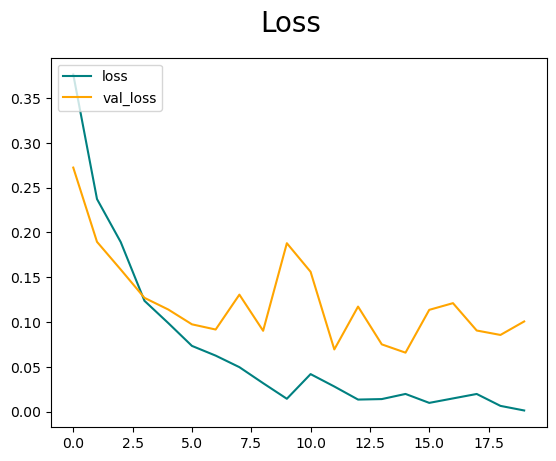

In [71]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

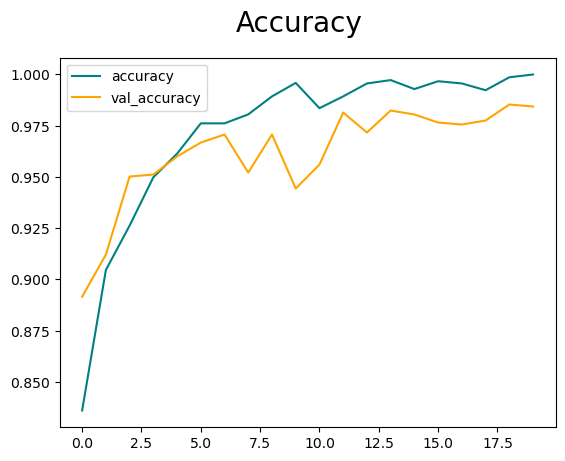

In [72]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [73]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [74]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [75]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


In [76]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.972549, shape=(), dtype=float32) tf.Tensor(0.98804784, shape=(), dtype=float32) tf.Tensor(0.98046875, shape=(), dtype=float32)


# 10. Test

!pip3 install opencv-python

In [77]:
import cv2

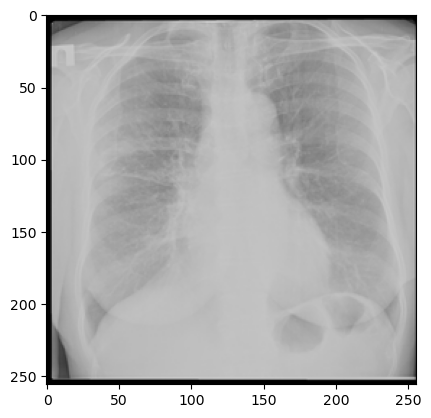

In [79]:
img = cv2.imread('TB (1004)-Copy1.png')
plt.imshow(img)
plt.show()

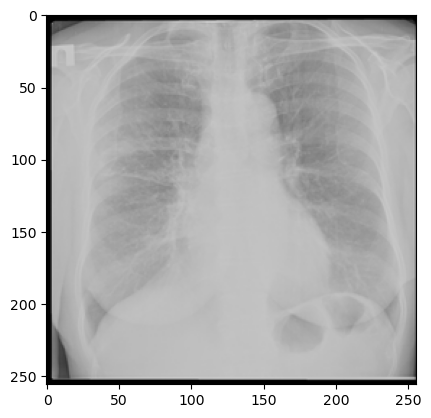

In [80]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [81]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [82]:
yhat

array([[1.]], dtype=float32)

In [83]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [84]:
from tensorflow.keras.models import load_model

In [85]:
model.save(os.path.join('models','my_tb_model.h5'))

new_model = load_model('models\my_model.h5')

In [44]:
prediction = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


In [45]:
prediction

array([[0.9991336]], dtype=float32)

In [46]:
if prediction > 0.5:
    print(f'the picture is predicted to be happy')
else:
    print(f'the picture is predicted to be sad')

the picture is predicted to be happy
